In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import jax.numpy as jnp
import jax
import equinox as eqx

from tqdm import tqdm
import typing as tp
import pandas as pd

import sys
sys.path.append("/home/korolevki/mcmc-control-variates/diffcv")

import optax

sns.set_style("darkgrid")

In [3]:
exp_results = pd.DataFrame()

## Experiment Params

In [4]:
DIST_DIM = 10 # Dimension of a Gaussian
N_CHAINS = 100 # Number of parallel chains for MCMC estimates
MCMC_N_ESTIMATES = 1000 # Number of MCMC estimates to calculate CI
BATCH_SIZE = 128 # Batch size for CV training

In [5]:
rng = jax.random.PRNGKey(50)

2024-08-02 21:05:05.501608: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Gaussian Mixture

In [6]:
import numpyro.distributions as D

# mixture = [
#     D.MultivariateNormal(loc=-10.0 * jnp.ones((DIST_DIM), dtype=float), covariance_matrix=jnp.eye((DIST_DIM), dtype=float)),
#     D.MultivariateNormal(loc=10.0 * jnp.ones((DIST_DIM), dtype=float), covariance_matrix=jnp.eye((DIST_DIM), dtype=float))
# ]
dist = D.MultivariateNormal(loc=10 * jnp.ones((DIST_DIM), dtype=float), covariance_matrix=jnp.eye((DIST_DIM), dtype=float)) #D.Mixture(D.Categorical(jnp.asarray([0.5, 0.5])), mixture)

grad_log_prob = jax.jit(jax.grad(dist.log_prob))

In [7]:
rng, key = jax.random.split(rng)
data = dist.sample(key, (10000,))

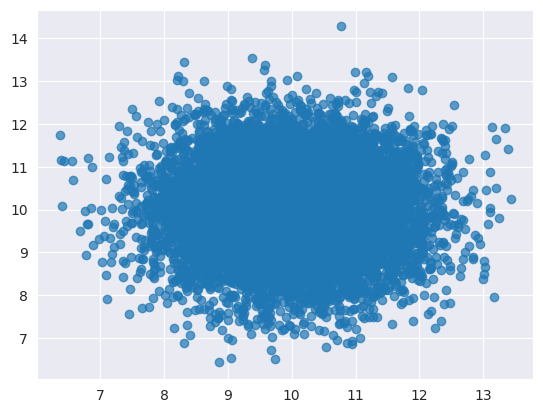

In [8]:
plt.scatter(data[:,0], data[:,1], alpha=0.7)
#plt.hist(data, bins=50, density=True)
plt.show()

## Sampler

In [9]:
from mcmc import ULASampler, HMCSampler

In [10]:
rng, key = jax.random.split(rng)
sampler = ULASampler(grad_log_prob=grad_log_prob, dim=DIST_DIM, n_samples=50, gamma=5e-2, burnin_steps=100, init_std=5.0)
#sampler = HMCSampler(log_prob=dist.log_prob, dim=DIST_DIM, n_samples=1000, gamma=1e-2, burnin_steps=1000, init_std=1.0)

False


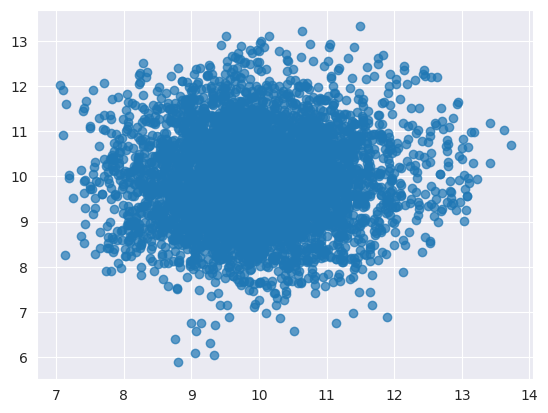

In [11]:
samples = sampler(key, n_chains=N_CHAINS)
samples = samples.reshape(-1, samples.shape[-1])

plt.scatter(samples[:,0], samples[:,1], alpha=0.7)
print(jnp.any(np.isnan(samples)))
#plt.hist(samples, bins=50, density=True)
plt.show()

## Baseline
Using a sample mean as an integral estimate

In [12]:
from mcmc import Estimator

In [13]:
fn = jax.jit(lambda x: x.sum(axis=-1))
true_pi = dist.mean.sum()

true_pi

Array(100., dtype=float32)

  0%|          | 0/1000 [00:00<?, ?it/s]

False


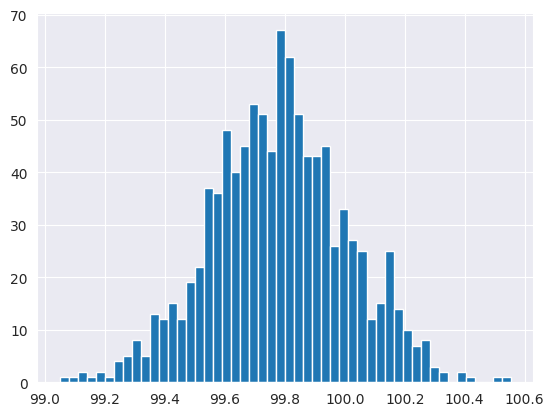

In [14]:
rng, key = jax.random.split(rng)
mcmc_estimates = Estimator(fn, sampler)(key, n_chains=N_CHAINS, n_estimates=MCMC_N_ESTIMATES)

print(jnp.any(jnp.isnan(mcmc_estimates)))
plt.hist(mcmc_estimates, bins=50)
plt.show()

In [15]:
exp_results["mcmc"] = mcmc_estimates

In [16]:
true_pi - exp_results.mean()

mcmc    0.22052
dtype: float32

In [17]:
exp_results.std()

mcmc    0.22724
dtype: float32

## Control variates (Eric's structural risk)
Train a NN with an objective from "Diffusion Approximations and Control Variates for MCMC"

In [18]:
from diffcv.cv import CVLinear, CVMLP, CVTrainer, CVLoss
from diffcv.logger import Logger
from diffcv.cv.data import get_data_from_sampler

2024-08-02 21:05:19.000187: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 21:05:19.000225: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 21:05:19.000250: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-02 21:05:19.910988: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [19]:
def plot_log_results(logger: Logger):
    log_results = logger.to_pandas()
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.lineplot(data=log_results["learning_rate"], ax=axes[0])
    sns.lineplot(data=log_results["loss"], ax=axes[1])
    fig.show()

In [20]:
rng, key = jax.random.split(rng)
dataset, dataloader = get_data_from_sampler(BATCH_SIZE, sampler, key, n_chains=N_CHAINS)
len(dataset)

5000

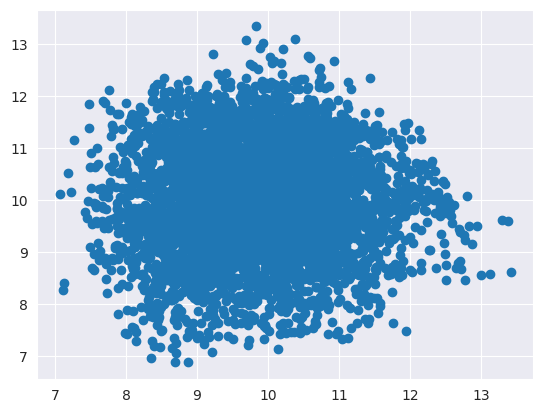

In [21]:
plt.scatter(x=dataset.arrays[0][:, 0], y=dataset.arrays[0][:, 1])
#plt.hist(dataset.arrays[0], bins=50)
plt.show()

In [87]:
from diffcv.cv.utils import recu, requ

  0%|          | 0/5000 [00:00<?, ?it/s]

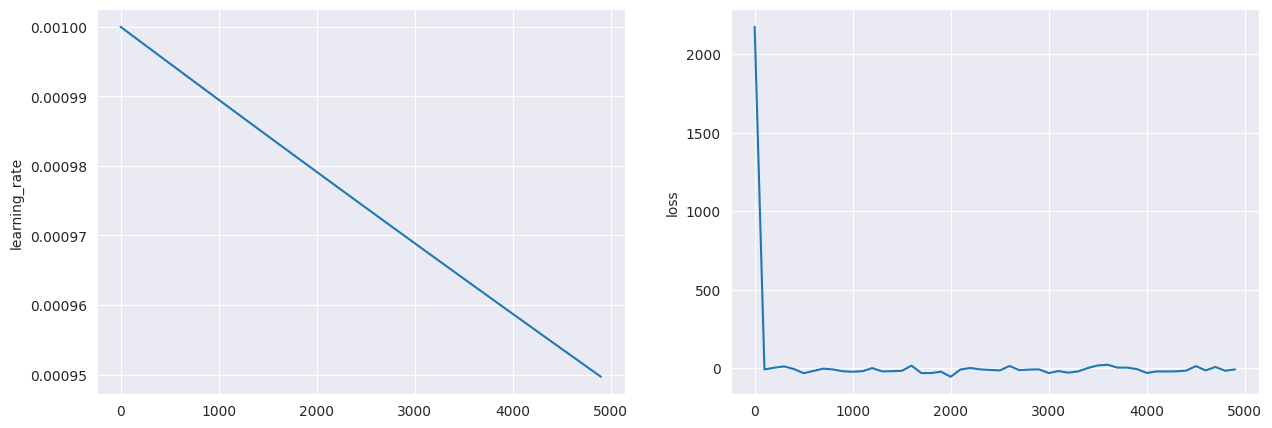

In [98]:
rng, key = jax.random.split(rng)
cv_model = CVMLP(in_size=DIST_DIM, depth=2, width_size=256, activation=requ, key=key) #CVLinear(in_size=DIST_DIM, key=key)

scheduler = optax.exponential_decay(init_value=1e-3, transition_steps=10_000, decay_rate=0.9)
optimizer = optax.inject_hyperparams(optax.adam)(learning_rate=scheduler)
fn_mean = jax.vmap(fn)(dataset.arrays[0]).mean()
loss = CVLoss(fn=fn, fn_mean=fn_mean, l2_alpha=10)

logger = Logger()

cv_trainer = CVTrainer(cv_model, dataloader, optimizer, loss, logger, n_steps=5_000)

rng, key = jax.random.split(rng)
cv_model = cv_trainer.train(key)

plot_log_results(logger)

In [99]:
# Check NN for nans
rng, key = jax.random.split(rng)
x = jax.random.normal(key, shape=(100, DIST_DIM))
y = jax.vmap(cv_model)(x)
print(jnp.any(jnp.isnan(y)))

False


In [100]:
from diffcv.cv import ScalarGenerator

In [101]:
# Expectation of generator with respect to distribution should be 0
generator = ScalarGenerator(grad_log_prob, cv_model)
jax.vmap(generator)(dataset.arrays[0]).mean()

Array(-0.01872554, dtype=float32)

In [102]:
fn_with_cv = lambda x: fn(x) + generator(x)

In [103]:
# Check generator for nans
rng, key = jax.random.split(rng)
x = 1000 * jax.random.normal(key, shape=(100, DIST_DIM))
y = jax.vmap(generator)(x)
print(np.any(np.isnan(y)))

False


  0%|          | 0/1000 [00:00<?, ?it/s]

False


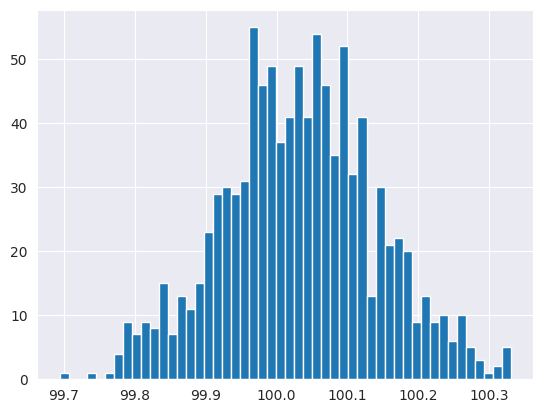

In [104]:
rng, key = jax.random.split(rng)
cv_estimates = Estimator(fn_with_cv, sampler)(key, n_chains=N_CHAINS, n_estimates=MCMC_N_ESTIMATES)

print(jnp.any(jnp.isnan(cv_estimates)))
plt.hist(cv_estimates, bins=50)
plt.show()

In [105]:
exp_results["diffusion_cv"] = cv_estimates

In [106]:
true_pi - exp_results.mean()

mcmc            0.220520
diffusion_cv   -0.032463
diff_loss      -0.000084
var_loss        0.000061
dtype: float32

In [107]:
exp_results.std()

mcmc            0.227240
diffusion_cv    0.108641
diff_loss       0.000103
var_loss        0.000146
dtype: float32

## Control variates (Diff Loss)

Use Stein equation to train NN on differences between different points

In [32]:
rng, key = jax.random.split(rng)
dataset, dataloader = get_data_from_sampler(BATCH_SIZE, sampler, key, n_chains=N_CHAINS)
len(dataset)

5000

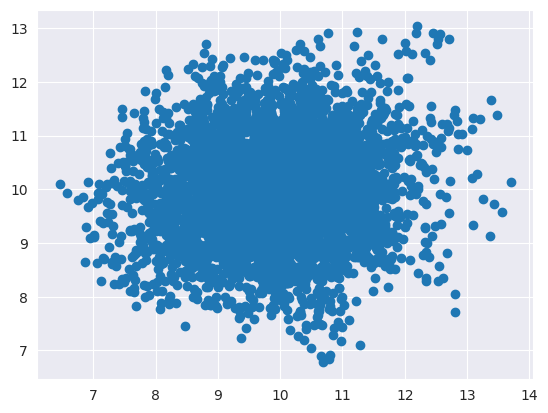

In [33]:
plt.scatter(x=dataset.arrays[0][:, 2], y=dataset.arrays[0][:, 6])
#plt.hist(dataset.arrays[0], bins=50)
plt.show()

In [34]:
from diffcv.cv import DiffLoss

  0%|          | 0/5000 [00:00<?, ?it/s]

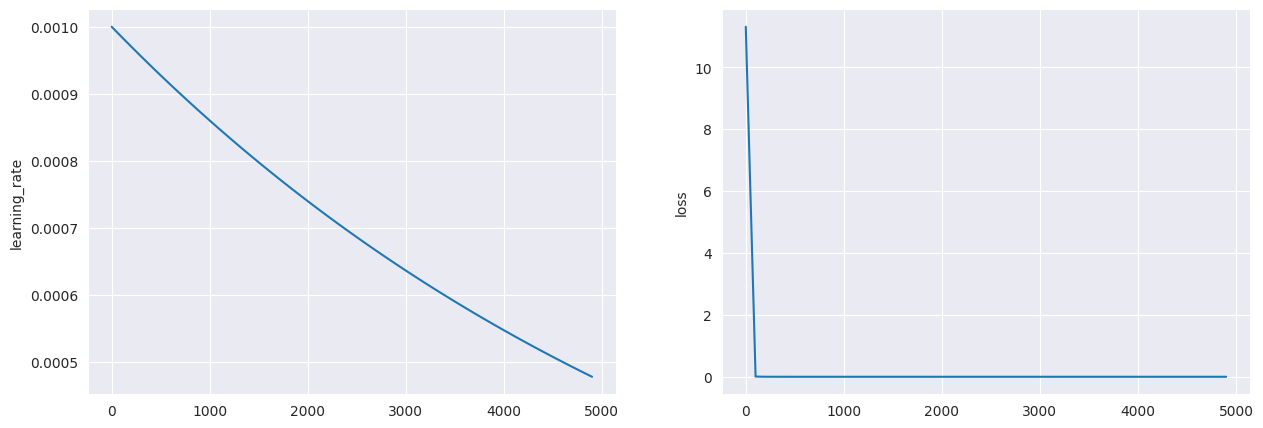

In [35]:
rng, key = jax.random.split(rng)
cv_diff_model = CVMLP(in_size=DIST_DIM, depth=2, width_size=128, key=key) #CVLinear(in_size=DIST_DIM, key=key)
scheduler = optax.exponential_decay(init_value=1e-3, transition_steps=700, decay_rate=0.9)
optimizer = optax.inject_hyperparams(optax.adam)(learning_rate=scheduler)
loss = DiffLoss(fn=fn, grad_log_prob=grad_log_prob)

logger = Logger()

cv_diff_trainer = CVTrainer(cv_diff_model, dataloader, optimizer, loss, logger, n_steps=5_000)
rng, key = jax.random.split(rng)
cv_diff_model = cv_diff_trainer.train(key)

plot_log_results(logger)

In [36]:
generator_diff = ScalarGenerator(grad_log_prob, cv_diff_model)
jax.vmap(generator_diff)(dataset.arrays[0]).mean()

Array(0.34623593, dtype=float32)

In [37]:
fn_with_cv_diff = lambda x: fn(x) + generator_diff(x)

  0%|          | 0/1000 [00:00<?, ?it/s]

False


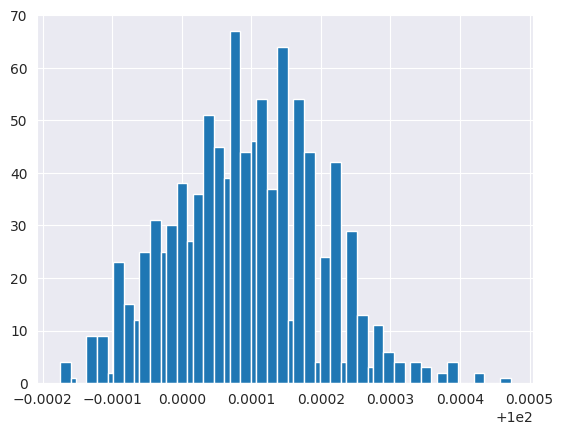

In [38]:
rng, key = jax.random.split(rng)
cv_diff_estimates = Estimator(fn_with_cv_diff, sampler)(key, n_chains=N_CHAINS, n_estimates=MCMC_N_ESTIMATES)

print(jnp.any(jnp.isnan(cv_diff_estimates)))
plt.hist(cv_diff_estimates, bins=50)
plt.show()

In [39]:
exp_results["diff_loss"] = cv_diff_estimates

In [40]:
true_pi - exp_results.mean()

mcmc            0.220520
diffusion_cv    0.018135
diff_loss      -0.000084
dtype: float32

In [41]:
exp_results.std()

mcmc            0.227240
diffusion_cv    0.078292
diff_loss       0.000103
dtype: float32

## Control Variates (Var Loss)

Minimize variance of the estimator directly

In [42]:
from diffcv.cv.loss import VarLoss

In [43]:
rng, key = jax.random.split(rng)
dataset, dataloader = get_data_from_sampler(BATCH_SIZE, sampler, key, n_chains=N_CHAINS)
len(dataset)

5000

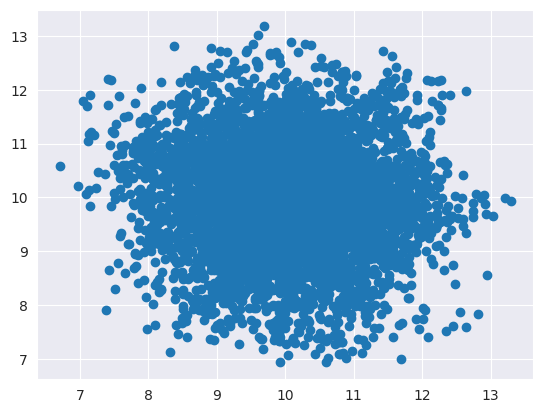

In [44]:
plt.scatter(x=dataset.arrays[0][:, 0], y=dataset.arrays[0][:, 1])
#plt.hist(dataset.arrays[0], bins=50)
plt.show()

In [70]:
class ModelWithConstant(eqx.Module):
    model: eqx.Module
    c: jax.Array
    
    def __init__(self, model: eqx.Module, shape, key: jax.random.PRNGKey):
        self.model = model
        self.c = jax.random.normal(key, shape)
    
    @eqx.filter_jit
    def __call__(self, x):
        return self.model(x)
    

rng, key = jax.random.split(rng)
g = CVMLP(in_size=DIST_DIM, depth=2, width_size=128, key=key) #CVLinear(in_size=DIST_DIM, key=key)

rng, key = jax.random.split(rng)
cv_var_model = ModelWithConstant(g, (1, ), key)

  0%|          | 0/200000 [00:00<?, ?it/s]

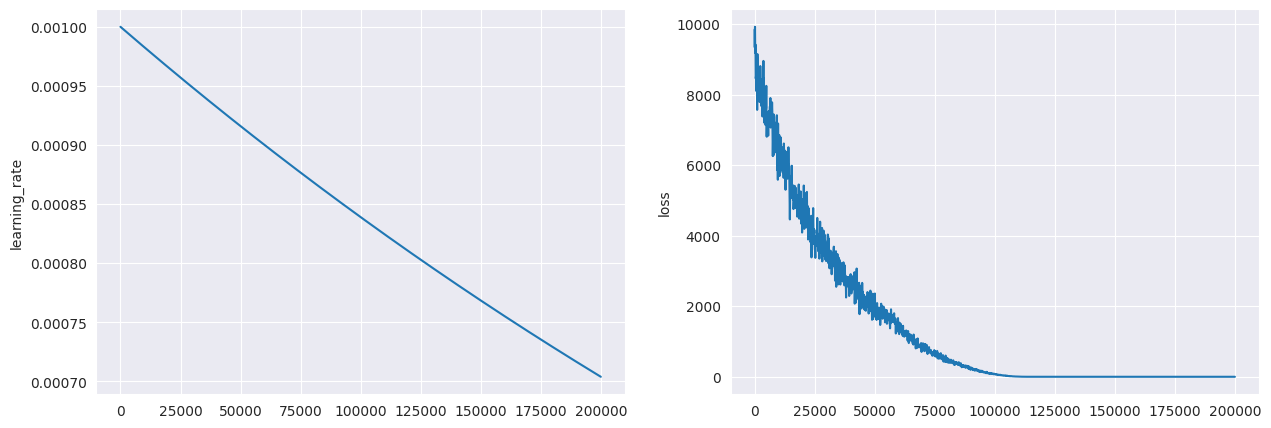

In [71]:
scheduler = optax.exponential_decay(init_value=1e-3, transition_steps=60_000, decay_rate=0.9)
optimizer = optax.inject_hyperparams(optax.adam)(learning_rate=scheduler)
loss = VarLoss(fn=fn, grad_log_prob=grad_log_prob)

logger = Logger()

cv_var_trainer = CVTrainer(cv_var_model, dataloader, optimizer, loss, logger, n_steps=200_000)
rng, key = jax.random.split(rng)
cv_var_model = cv_var_trainer.train(key)

plot_log_results(logger)

In [72]:
cv_var_model.c

Array([99.99983], dtype=float32)

In [73]:
generator_var = ScalarGenerator(grad_log_prob, cv_var_model.model)
jax.vmap(generator_var)(dataset.arrays[0]).mean()

Array(0.16345078, dtype=float32)

In [74]:
fn_with_cv_var = lambda x: fn(x) + generator_var(x)

  0%|          | 0/1000 [00:00<?, ?it/s]

False


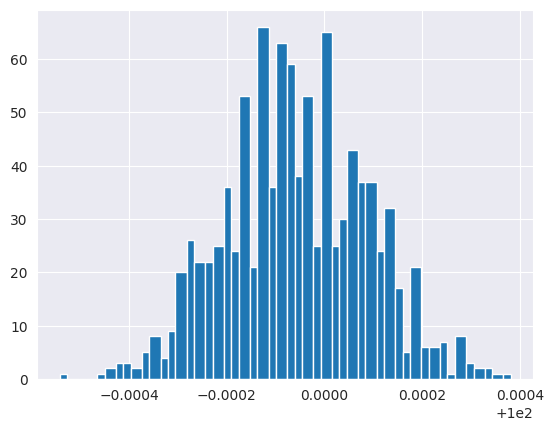

In [75]:
rng, key = jax.random.split(rng)
cv_var_estimates = Estimator(fn_with_cv_var, sampler)(key, n_chains=N_CHAINS, n_estimates=MCMC_N_ESTIMATES)

print(jnp.any(jnp.isnan(cv_var_estimates)))
plt.hist(cv_var_estimates, bins=50)
plt.show()

In [76]:
exp_results["var_loss"] = cv_var_estimates

In [77]:
true_pi - exp_results.mean()

mcmc            0.220520
diffusion_cv    0.018135
diff_loss      -0.000084
var_loss        0.000061
dtype: float32

In [78]:
exp_results.std()

mcmc            0.227240
diffusion_cv    0.078292
diff_loss       0.000103
var_loss        0.000146
dtype: float32